<a href="https://colab.research.google.com/github/KFurudate/RStanBook/blob/main/Chapter_10_1_4_multinomial_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 多項ロジスティック回帰

目的：どのような年齢・性別・年収の人がどのカテゴリーを選びやすかを知ること

In [1]:
DAY="20201217"

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls drive/MyDrive/RStanBook_アヒル本/

Mounted at /content/drive
'Chapter 10_1_4_multinomial_logistic_regression.ipynb'
 input
 output
 RStanBook-master
'StanとRでベイズ統計モデリング Wonderful R 2 松浦 健太郎 282p_B07M8LWLS1.pdf'


In [3]:
!chmod -R 777 drive/MyDrive/RStanBook_アヒル本/input
!ls -all drive/MyDrive/RStanBook_アヒル本/input

total 147
-rwx------ 1 root root   921 May 10  2020 d1.csv
-rwx------ 1 root root  1116 May 10  2020 data-2Dmesh-design.txt
-rwx------ 1 root root  1908 May 10  2020 data-2Dmesh.txt
-rwx------ 1 root root   979 May 10  2020 data3a.csv
-rwx------ 1 root root  1145 May 10  2020 data4a.csv
-rwx------ 1 root root   816 May 10  2020 data-50m.txt
-rwx------ 1 root root   497 May 10  2020 data7a.csv
-rwx------ 1 root root  1680 May 10  2020 data-aircon.txt
-rwx------ 1 root root   593 May 10  2020 data-attendance-1.txt
-rwx------ 1 root root   751 May 10  2020 data-attendance-2.txt
-rwx------ 1 root root 30253 May 10  2020 data-attendance-3.txt
-rwx------ 1 root root   447 May 10  2020 data-attendance-4-1.txt
-rwx------ 1 root root 21347 May 10  2020 data-attendance-4-2.txt
-rwx------ 1 root root  1114 May 10  2020 data-attendance-5.txt
-rwx------ 1 root root  3317 May 10  2020 data-category.txt
-rwx------ 1 root root  3614 May 10  2020 data-changepoint.txt
-rwx------ 1 root root   202 May 10

In [4]:
!pip install pymc3==3.10.0
!pip install Theano==1.0.5

     |████████████████████████████████| 1.9MB 5.3MB/s 
     |████████████████████████████████| 2.8MB 14.0MB/s 
     |████████████████████████████████| 1.5MB 35.9MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 737kB 36.3MB/s 
     |████████████████████████████████| 4.3MB 49.9MB/s 
     |████████████████████████████████| 296kB 45.8MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=ba8fcc0af844f92a3e7aebc70233486c0694131fee618022c138db30629b95a5
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for theano-pymc: filename=Theano_PyMC-1.0.11-cp36-none-any.whl size=2572023 sha256=21be0d706df972424a72e98a6a0f99144ee356eeee8e1f12f2a7b4bfa4982c90
  Stored in directory: /root/.cache/pip/wheels/26/b2/77/4ee2bb9b1c1de7de771254a5e379d898273d8114237b0df686
Successfully built contextvars theano-pymc
  Found existing installation:

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import pymc3 as pm
import theano
import theano.tensor as tt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [6]:
PATH="drive/MyDrive/RStanBook_アヒル本/"

In [7]:
!mkdir -p drive/MyDrive/RStanBook_アヒル本/output/$DAY

In [8]:
outdir = f"drive/MyDrive/Phylogeny/output/{DAY}/"

In [9]:
INPUT1 = "data-category.txt"

In [10]:
df = pd.read_csv(PATH + f"input/{INPUT1}")
df

,Age,Sex,Income,Y
0,18,1,472,2
1,18,0,468,5
2,18,1,451,6
3,18,1,441,6
4,18,1,499,6
...,...,...,...,...
295,55,1,432,1
296,55,1,531,1
297,55,0,369,4
298,55,1,690,2


In [11]:
X = df[['Age','Sex','Income']].values
Y = df.Y - 1
# カテゴリ数 
K = len(df.Y.unique())

In [12]:
with pm.Model() as model:
    # カテゴリ１を選ぶ強さを0に固定する→残りのカテゴリを選ぶ強さはカテゴリ1との比較から決まる
    # パラメータ数は、後で0を加えるため、カテゴリ数-1になる。
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=(K-1,))
    beta = pm.Normal('beta', mu=0, sd=100, shape=(3,K-1))

    # 各パラメータの1つを0に固定化する。
    alpha_f = pm.Deterministic('alpha_f', tt.concatenate([tt.zeros(1), alpha]))
    beta_f = pm.Deterministic('beta_f', tt.concatenate([tt.zeros((3,1)) , beta], axis=1))

    #
    mu = alpha_f + pm.math.dot(X, beta_f)
    theta = tt.nnet.softmax(mu)
    y = pm.Categorical('y', p=theta, observed=Y)

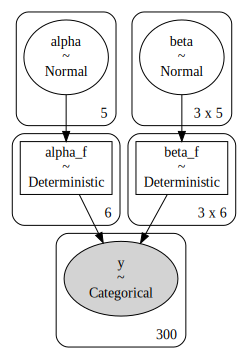

In [13]:
ret = pm.model_to_graphviz(model)
ret.render(filename=outdir + f'{DAY}_model', format='png')
ret

In [14]:
with model:
    start = pm.find_MAP(method='Powell')
    step = pm.NUTS()
    trace_sf = pm.sample(3000, step=step, init="advi")

Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 134 seconds.


ValueError: ignored

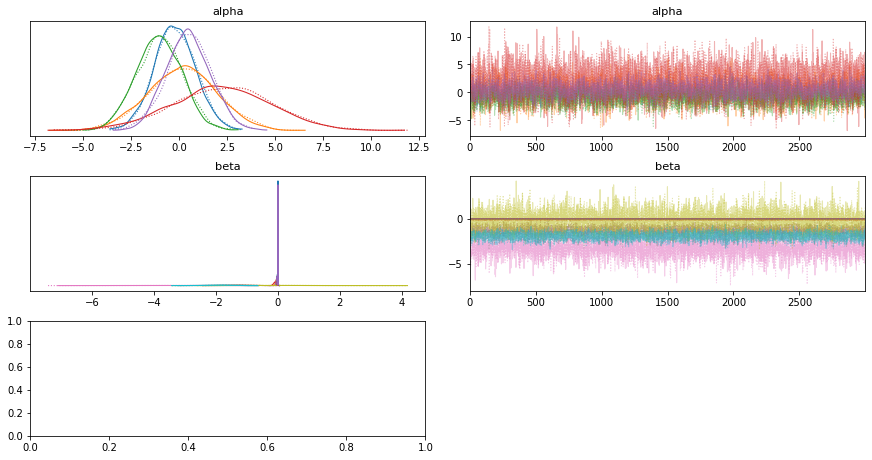

In [15]:
_ = pm.traceplot(trace_sf)

In [ ]:
pm.summary(trace_sf)